## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
Aim is to segement the Customers based on RFM so that the company can target its customers efficiently.

#### The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Data Preparation](#3)
1. [Step 4: Model Building](#4)
1. [Step 5: Final Analysis](#5)

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

In [ ]:
# import required libraries for dataframe and visualization
!apt-get install python3.6
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from datetime import datetime
import datetime as dt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.6 is already the newest version (3.6.9-1~18.04ubuntu1.4).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
# Reading the data on which analysis needs to be done

retail = pd.read_excel('LRFMV_data_v2.xlsx')
retail.head()

,item id,customer id,total sales,invoice id,ship date
0,1048834,U55560,202.20,398164,2020-03-03
1,1043579,U47675,150.77,428137,2020-06-18
2,7203484,U45465,180.28,448927,2020-09-16
3,1018534,E94146,134.53,20001643,2020-02-18
4,1022413,U59076,74.20,390693,2020-02-10


In [ ]:
# shape of df

retail.shape

(413558, 5)

In [ ]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413558 entries, 0 to 413557
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   item id      413558 non-null  object        
 1   customer id  413558 non-null  object        
 2   total sales  413558 non-null  float64       
 3   invoice id   413558 non-null  object        
 4   ship date    413558 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 15.8+ MB


In [ ]:
# df description

retail.describe()

,total sales
count,413558.000000
mean,708.972992
std,2246.611463
min,-82058.100000
25%,97.762500
50%,259.680000
75%,657.920000
max,339900.000000


<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [ ]:
retail.columns = retail.columns.str.replace(' ','_')

In [ ]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

item_id        0.0
customer_id    0.0
total_sales    0.0
invoice_id     0.0
ship_date      0.0
dtype: float64

In [ ]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(413558, 5)

In [ ]:
retail.dtypes

item_id                object
customer_id            object
total_sales           float64
invoice_id             object
ship_date      datetime64[ns]
dtype: object

In [ ]:
# Changing the datatype of Customer Id as per Business understanding

retail['customer_id'] = retail['customer_id'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

# Length

In [ ]:
rfm_l = retail.groupby(['customer_id'])['ship_date'].max().reset_index()
rfm_l.columns = ['customer_id', 'ship_date_max']
rfm_l.head()

,customer_id,ship_date_max
0,A89022,2021-02-19
1,A89031,2020-08-12
2,A89042,2021-02-16
3,A89045,2021-01-06
4,A89046,2020-10-07


In [ ]:
rfm_l2 = retail.groupby(['customer_id'])['ship_date'].min().reset_index()
rfm_l2.columns = ['customer_id', 'ship_date_min']
rfm_l2.head()

,customer_id,ship_date_min
0,A89022,2020-01-15
1,A89031,2020-01-07
2,A89042,2020-01-14
3,A89045,2020-01-02
4,A89046,2020-01-20


In [ ]:
rfm_l2['Length'] = rfm_l['ship_date_max'] - rfm_l2['ship_date_min']

In [ ]:
rfm_l2 = rfm_l2.reset_index()

In [ ]:
rfm_l2['Length'] = rfm_l2['Length'].dt.days.astype(int)

In [ ]:
rfm_l2['Length'] = rfm_l2['Length'] + 1

In [ ]:
rfm_l2.head()

,index,customer_id,ship_date_min,Length
0,0,A89022,2020-01-15,402
1,1,A89031,2020-01-07,219
2,2,A89042,2020-01-14,400
3,3,A89045,2020-01-02,371
4,4,A89046,2020-01-20,262


In [ ]:
rfm_l2 = rfm_l2.drop(columns = ['index', 'ship_date_min'])

# Monetary

In [ ]:
# New Attribute : Monetary

rfm_m = retail.groupby('customer_id')['total_sales'].sum() 
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['customer_id', 'Monetary']
rfm_m.head()

,customer_id,Monetary
0,A89022,49260.12
1,A89031,37091.37
2,A89042,138822.43
3,A89045,54509.25
4,A89046,8601.26


In [ ]:
rfm_m['Monetary_per_day'] = rfm_m['Monetary']/rfm_l2['Length']

In [ ]:
rfm_m.head()

,customer_id,Monetary,Monetary_per_day
0,A89022,49260.12,122.537612
1,A89031,37091.37,169.366986
2,A89042,138822.43,347.056075
3,A89045,54509.25,146.925202
4,A89046,8601.26,32.829237


In [ ]:
rfm_m = rfm_m.drop(columns = ['Monetary'])

# Frequency

In [ ]:
# New Attribute : Frequency

rfm_f = retail.groupby('customer_id')['invoice_id'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['customer_id', 'Frequency']
rfm_f.head()

,customer_id,Frequency
0,A89022,14
1,A89031,14
2,A89042,63
3,A89045,16
4,A89046,14


## Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

In [ ]:
rfm_f['Frequency_per_day'] = rfm_f['Frequency']/rfm_l2['Length']

In [ ]:
rfm_f.head()

,customer_id,Frequency,Frequency_per_day
0,A89022,14,0.034826
1,A89031,14,0.063927
2,A89042,63,0.157500
3,A89045,16,0.043127
4,A89046,14,0.053435


In [ ]:
rfm_f = rfm_f.drop(columns = ['Frequency'])

# Variety

In [ ]:
rfm_v = retail.groupby('customer_id').item_id.nunique()
rfm_v = rfm_v.reset_index()
rfm_v.columns = ['customer_id', 'Variety']
rfm_v.head()

,customer_id,Variety
0,A89022,3
1,A89031,7
2,A89042,25
3,A89045,5
4,A89046,5


# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

# Recency

In [ ]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['ship_date'] = pd.to_datetime(retail['ship_date'],format='%d-%m-%Y %H:%M')

In [ ]:
# Compute the maximum date to know the last transaction date

min_date = min(retail['ship_date'])

In [ ]:
min_date

Timestamp('2020-01-02 00:00:00')

In [ ]:
rfm_r = retail.groupby(['customer_id'])['ship_date'].max().reset_index()
rfm_r.columns = ['customer_id', 'ship_date_max']
rfm_r.head()

,customer_id,ship_date_max
0,A89022,2021-02-19
1,A89031,2020-08-12
2,A89042,2021-02-16
3,A89045,2021-01-06
4,A89046,2020-10-07


In [ ]:
rfm_r['Recency'] = [(date-min_date).days for date in list(rfm_r['ship_date_max'])]
rfm_r

,customer_id,ship_date_max,Recency
0,A89022,2021-02-19,414
1,A89031,2020-08-12,223
2,A89042,2021-02-16,411
3,A89045,2021-01-06,370
4,A89046,2020-10-07,279
...,...,...,...
2362,U96070,2021-01-25,389
2363,U99022,2020-01-22,20
2364,U99025,2021-03-11,434
2365,Z495,2020-01-28,26


In [ ]:
rfm_r = rfm_r.drop(columns = ['ship_date_max'])

In [ ]:
master = rfm_m.merge(rfm_f, on='customer_id', how='inner')
#rfm.columns = ['customerID', 'Length', 'Recency', 'Frequency', 'Monetary', 'Variety']
master.head()

,customer_id,Monetary_per_day,Frequency_per_day
0,A89022,122.537612,0.034826
1,A89031,169.366986,0.063927
2,A89042,347.056075,0.157500
3,A89045,146.925202,0.043127
4,A89046,32.829237,0.053435


In [ ]:
RFM = rfm_r.merge(rfm_v, on = 'customer_id', how = 'inner')
RFM.head()

,customer_id,Recency,Variety
0,A89022,414,3
1,A89031,223,7
2,A89042,411,25
3,A89045,370,5
4,A89046,279,5


In [ ]:
RFM = RFM.merge(master, on = 'customer_id')
RFM.head()

,customer_id,Recency,Variety,Monetary_per_day,Frequency_per_day
0,A89022,414,3,122.537612,0.034826
1,A89031,223,7,169.366986,0.063927
2,A89042,411,25,347.056075,0.157500
3,A89045,370,5,146.925202,0.043127
4,A89046,279,5,32.829237,0.053435


In [ ]:
L = rfm_l2.merge(rfm_m, on = 'customer_id', how = 'inner')
L.head()

,customer_id,Length,Monetary_per_day
0,A89022,402,122.537612
1,A89031,219,169.366986
2,A89042,400,347.056075
3,A89045,371,146.925202
4,A89046,262,32.829237


In [ ]:
L = L.drop(columns = ['Monetary_per_day'])

In [ ]:
RFM = RFM.merge(L, on = 'customer_id' )
RFM.head()

,customer_id,Recency,Variety,Monetary_per_day,Frequency_per_day,Length
0,A89022,414,3,122.537612,0.034826,402
1,A89031,223,7,169.366986,0.063927,219
2,A89042,411,25,347.056075,0.157500,400
3,A89045,370,5,146.925202,0.043127,371
4,A89046,279,5,32.829237,0.053435,262


In [ ]:
RFM = RFM[['customer_id', 'Length', 'Recency', 'Frequency_per_day', 'Monetary_per_day', 'Variety']]
RFM.head()

,customer_id,Length,Recency,Frequency_per_day,Monetary_per_day,Variety
0,A89022,402,414,0.034826,122.537612,3
1,A89031,219,223,0.063927,169.366986,7
2,A89042,400,411,0.157500,347.056075,25
3,A89045,371,370,0.043127,146.925202,5
4,A89046,262,279,0.053435,32.829237,5


Text(0.5, 0, 'Attributes')

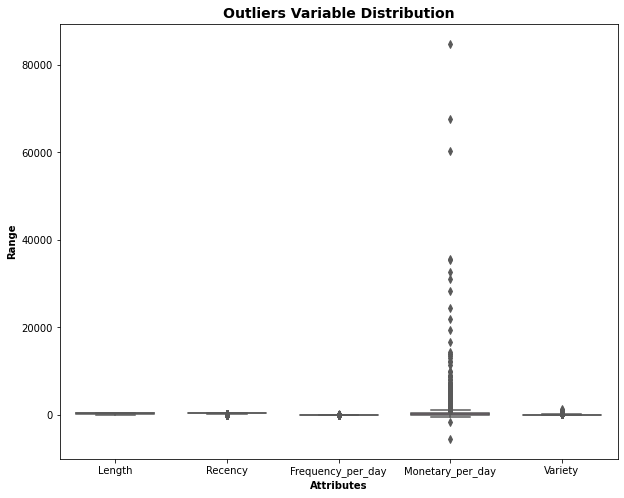

In [ ]:
# Outlier Analysis 

attributes = ['Length', 'Recency', 'Frequency_per_day', 'Monetary_per_day', 'Variety']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = RFM[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers 
Q1 = RFM.Length.quantile(0.25)
Q3 = RFM.Length.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Length >= Q1 - 1.5*IQR) & (RFM.Length <= Q3 + 1.5*IQR)]

Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]
                                                                                    
Q1 = RFM.Frequency_per_day.quantile(0.25)
Q3 = RFM.Frequency_per_day.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency_per_day >= Q1 - 1.5*IQR) & (RFM.Frequency_per_day <= Q3 + 1.5*IQR)]

Q1 = RFM.Monetary_per_day.quantile(0.25)
Q3 = RFM.Monetary_per_day.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Monetary_per_day >= Q1 - 1.5*IQR) & (RFM.Monetary_per_day <= Q3 + 1.5*IQR)]

Q1 = RFM.Variety.quantile(0.25)
Q3 = RFM.Variety.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Variety >= Q1 - 1.5*IQR) & (RFM.Variety <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

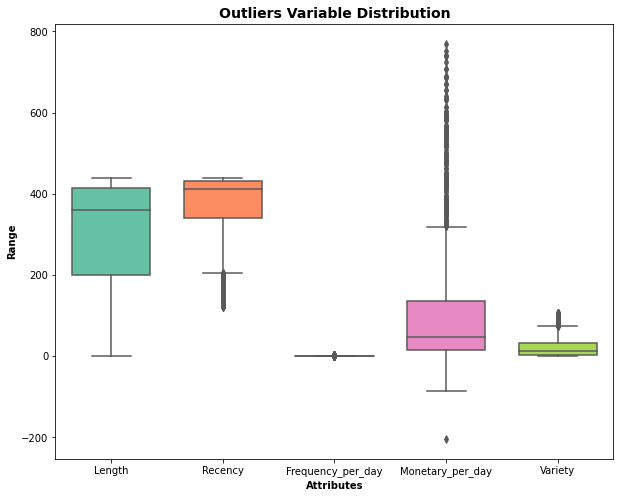

In [ ]:
# Outlier Analysis 

attributes = ['Length', 'Recency', 'Frequency_per_day', 'Monetary_per_day', 'Variety']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = RFM[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Rescaling the attributes

lrfmv_df = RFM[['Length', 'Recency', 'Frequency_per_day', 'Monetary_per_day', 'Variety']]

# Instantiate
scaler = StandardScaler()

# fit_transform
lrfmv_df_scaled = scaler.fit_transform(lrfmv_df)
lrfmv_df_scaled.shape

(1601, 5)

In [ ]:
lrfmv_df_scaled = pd.DataFrame(lrfmv_df_scaled)
lrfmv_df_scaled.columns = ['Length', 'Recency', 'Frequency_per_day', 'Monetary_per_day', 'Variety']
lrfmv_df_scaled.head()

,Length,Recency,Frequency_per_day,Monetary_per_day,Variety
0,0.740255,0.510924,-0.546933,0.086928,-0.762455
1,-0.526091,-1.848992,-0.457825,0.403723,-0.599626
2,0.726415,0.473857,-0.171300,1.605770,0.133106
3,0.525737,-0.032722,-0.521516,0.251907,-0.681040
4,-0.228535,-1.157079,-0.489951,-0.519939,-0.681040


Text(0.5, 0, 'Attributes')

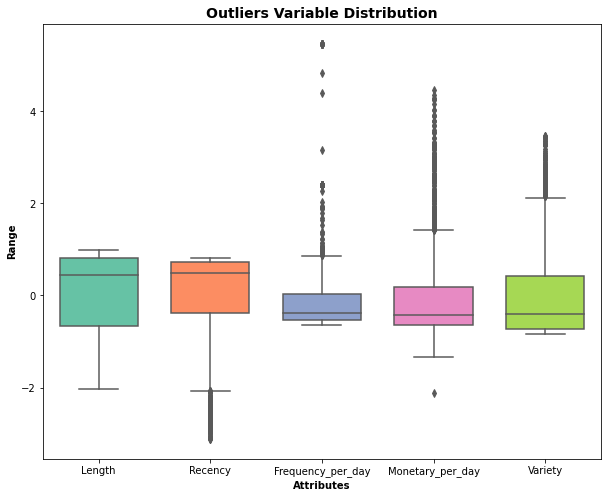

In [ ]:
# Outlier Analysis 

attributes = ['Length', 'Recency', 'Frequency_per_day', 'Monetary_per_day', 'Variety']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = lrfmv_df_scaled[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
l = []

In [ ]:
#!pip install yellowbrick==1.3.post1

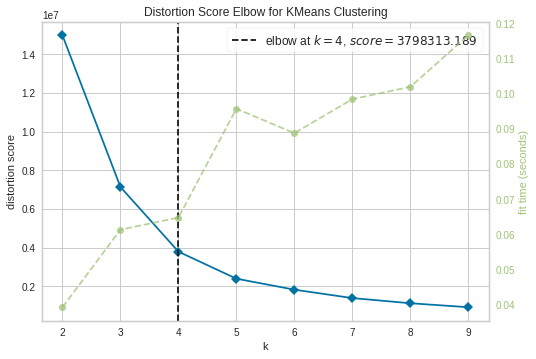

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f171a699790>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=9,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto', random_state=4,
                                  tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

X, y = load_nfl()

# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=4), X, k=(2,10))

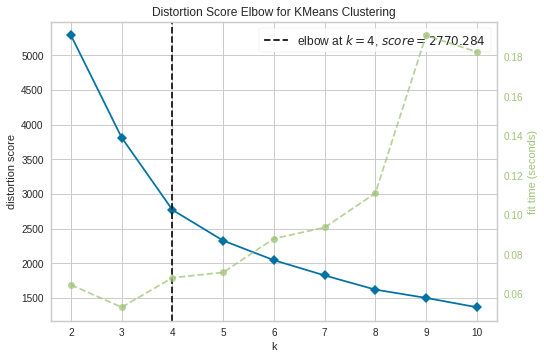

In [ ]:
# Distortion Method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10))

visualizer.fit(lrfmv_df_scaled)     
visualizer.show()  

In [ ]:
l.append(visualizer.elbow_value_)

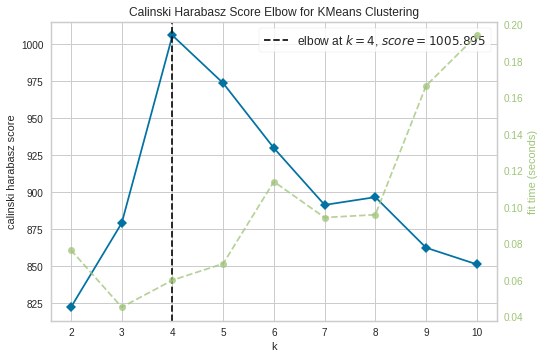

In [ ]:
# Calinski_harabasz Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10), metric='calinski_harabasz')

visualizer.fit(lrfmv_df_scaled)        
visualizer.show()        

In [ ]:
l.append(visualizer.elbow_value_)

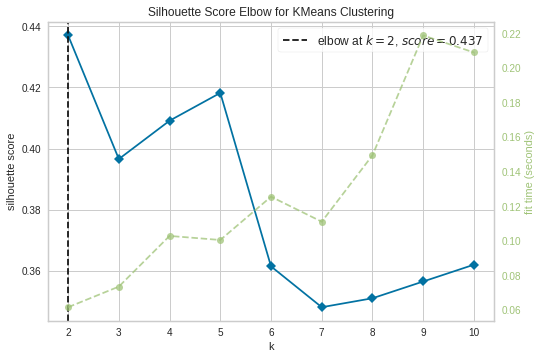

In [ ]:
# Silhouette Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10), metric='silhouette')

visualizer.fit(lrfmv_df_scaled)        
visualizer.show() 

In [ ]:
l.append(visualizer.elbow_value_)

In [ ]:
print(max(set(l), key = l.count))

4


In [ ]:
avg = sum(l)/len(l)
print("The average is ", round(avg))

The average is  3


In [ ]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=100)
kmeans.fit(lrfmv_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans.labels_

array([1, 2, 0, ..., 2, 1, 1], dtype=int32)

In [ ]:
# assign the label
RFM['Cluster_Id'] = kmeans.labels_
RFM.head()

,customer_id,Length,Recency,Frequency_per_day,Monetary_per_day,Variety,Cluster_Id
0,A89022,402,414,0.034826,122.537612,3,1
1,A89031,219,223,0.063927,169.366986,7,2
2,A89042,400,411,0.157500,347.056075,25,0
3,A89045,371,370,0.043127,146.925202,5,1
4,A89046,262,279,0.053435,32.829237,5,2


In [ ]:
lrfmv_df_scaled['Cluster_Id'] = kmeans.labels_
lrfmv_df_scaled.head()

,Length,Recency,Frequency_per_day,Monetary_per_day,Variety,Cluster_Id
0,0.740255,0.510924,-0.546933,0.086928,-0.762455,1
1,-0.526091,-1.848992,-0.457825,0.403723,-0.599626,2
2,0.726415,0.473857,-0.171300,1.605770,0.133106,0
3,0.525737,-0.032722,-0.521516,0.251907,-0.681040,1
4,-0.228535,-1.157079,-0.489951,-0.519939,-0.681040,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


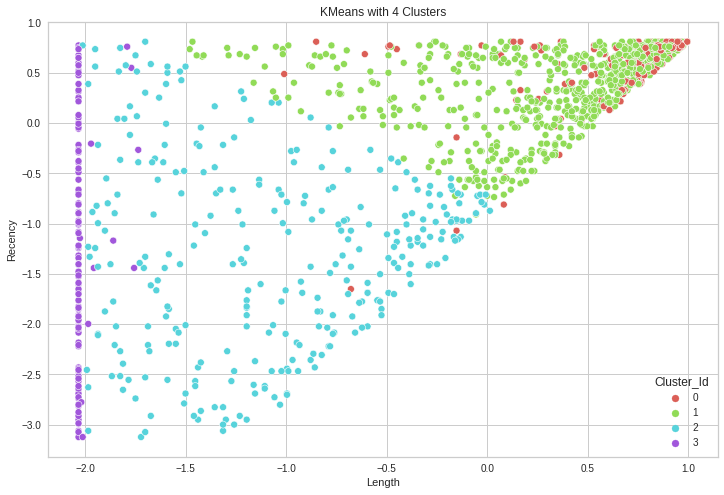

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(lrfmv_df_scaled['Length'], lrfmv_df_scaled['Recency'], hue=lrfmv_df_scaled['Cluster_Id'], 
                palette=sns.color_palette('hls', 4))
plt.title('KMeans with 4 Clusters')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


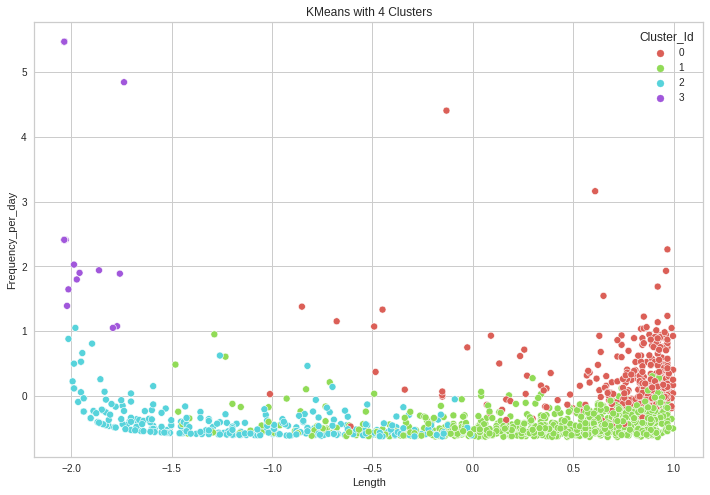

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(lrfmv_df_scaled['Length'], lrfmv_df_scaled['Frequency_per_day'], hue=lrfmv_df_scaled['Cluster_Id'], 
                palette=sns.color_palette('hls', 4))
plt.title('KMeans with 4 Clusters')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


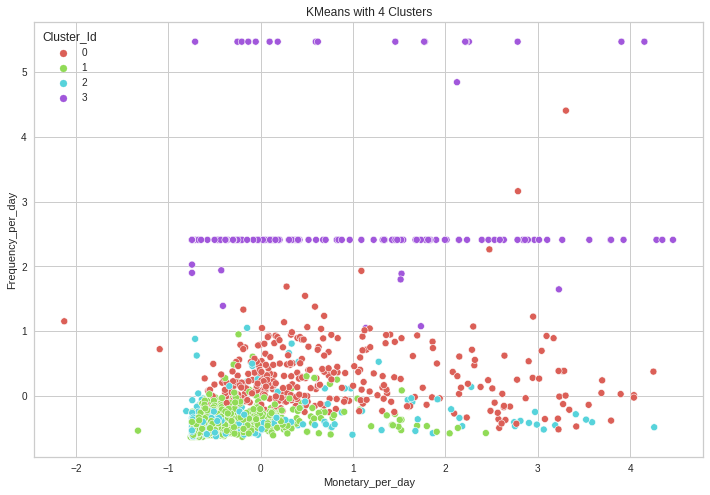

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(lrfmv_df_scaled['Monetary_per_day'], lrfmv_df_scaled['Frequency_per_day'], hue=lrfmv_df_scaled['Cluster_Id'], 
                palette=sns.color_palette('hls', 4))
plt.title('KMeans with 4 Clusters')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


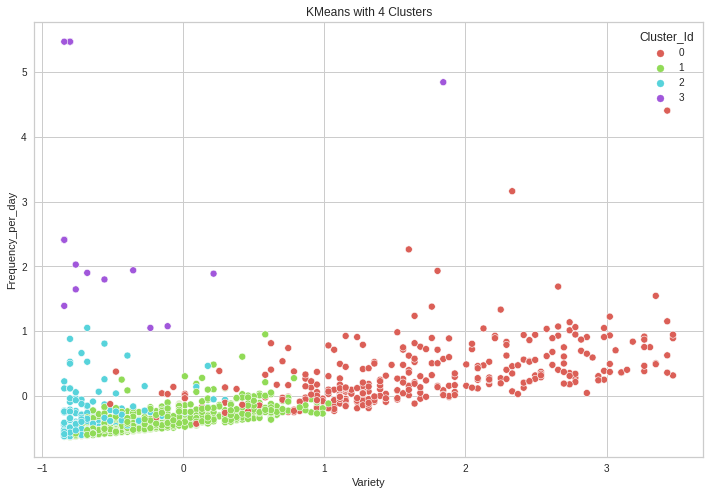

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(lrfmv_df_scaled['Variety'], lrfmv_df_scaled['Frequency_per_day'], hue=lrfmv_df_scaled['Cluster_Id'], 
                palette=sns.color_palette('hls', 4))
plt.title('KMeans with 4 Clusters')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


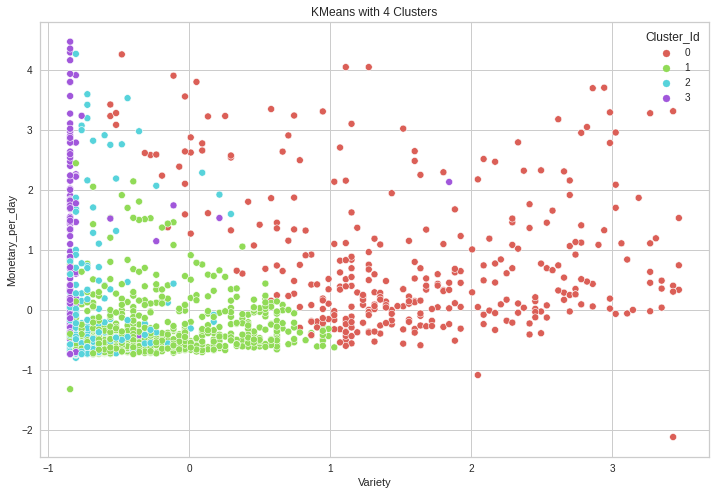

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(lrfmv_df_scaled['Variety'], lrfmv_df_scaled['Monetary_per_day'], hue=lrfmv_df_scaled['Cluster_Id'], 
                palette=sns.color_palette('hls', 4))
plt.title('KMeans with 4 Clusters')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


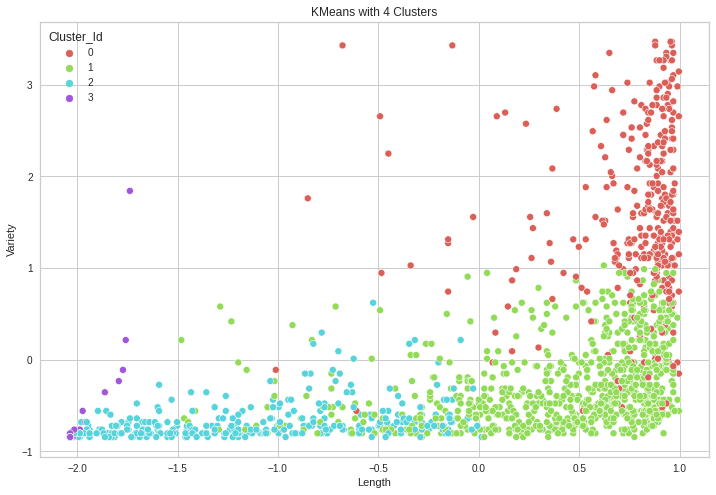

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(lrfmv_df_scaled['Length'], lrfmv_df_scaled['Variety'], hue=lrfmv_df_scaled['Cluster_Id'], 
                palette=sns.color_palette('hls', 4))
plt.title('KMeans with 4 Clusters')
plt.show()

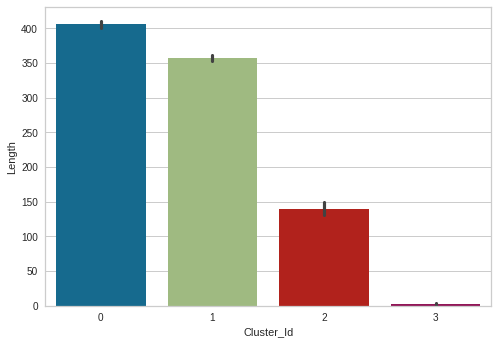

In [ ]:
sns.barplot(x='Cluster_Id', y='Length', data=RFM)

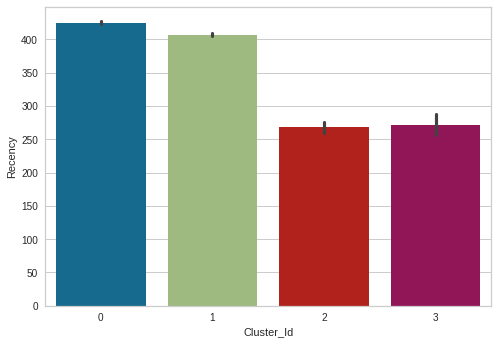

In [ ]:
sns.barplot(x='Cluster_Id', y='Recency', data=RFM)

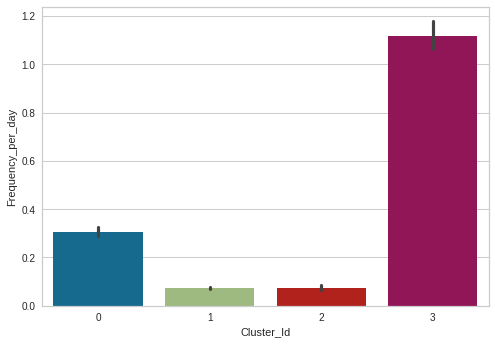

In [ ]:
sns.barplot(x='Cluster_Id', y='Frequency_per_day', data=RFM)

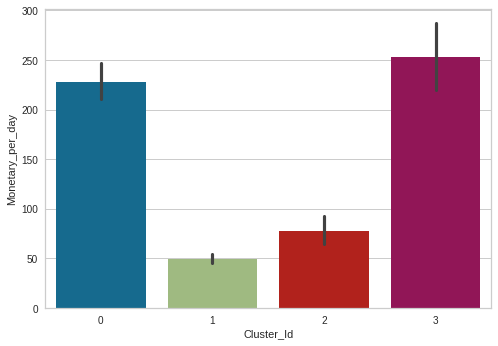

In [ ]:
sns.barplot(x='Cluster_Id', y='Monetary_per_day', data=RFM)

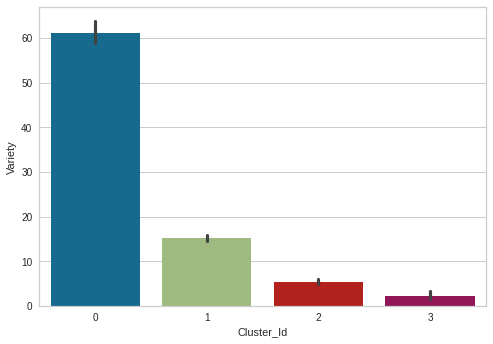

In [ ]:
sns.barplot(x='Cluster_Id', y='Variety', data=RFM)